# Modelos de clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

Como primer paso analizamos la posible correlación entre los ratios obtenidos en el notbook ratios

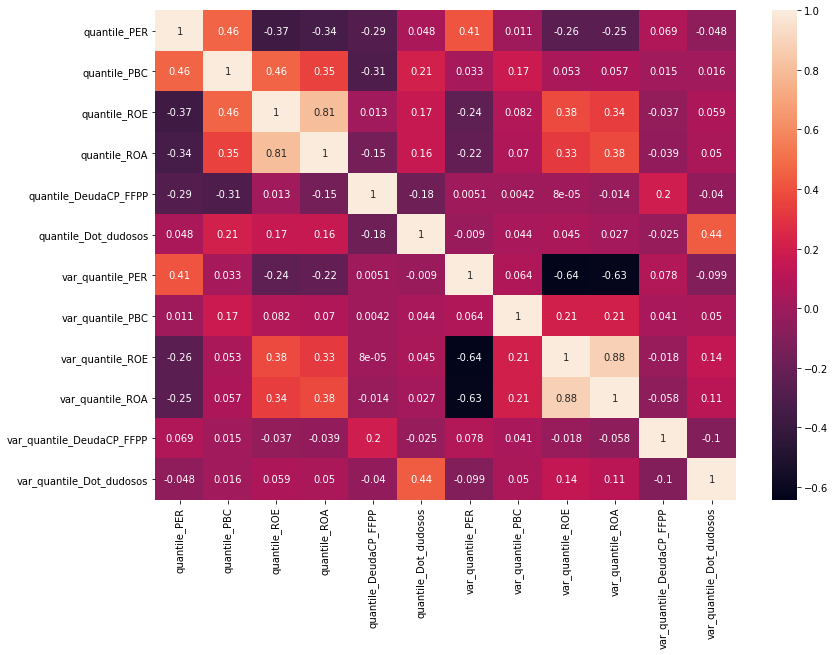

In [2]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_ROA', 'var_quantile_ROA',
                                                        'quantile_ROE', 'var_quantile_ROE',
                                                        'quantile_DeudaCP_FFPP', 'var_quantile_DeudaCP_FFPP',
                                                        'quantile_Dot_dudosos', 'var_quantile_Dot_dudosos',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Podemos observar una correlación muy fuerte entre el ROE y el ROA, así que prescindimos del ROE, así como de su variación

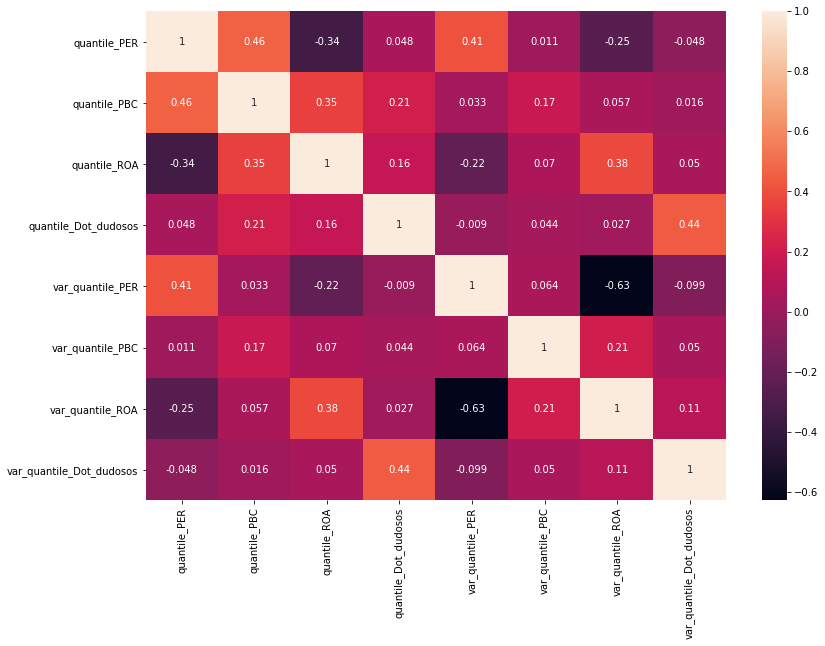

In [3]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_ROA', 'var_quantile_ROA',
                                                        'quantile_Dot_dudosos', 'var_quantile_Dot_dudosos',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Eliminamos nans

In [4]:
df=df.replace([np.inf, -np.inf], np.nan)
for column in df.columns:
    df=df[df[column].notnull()]
df=df.reset_index(drop=True)

In [5]:
df.describe()

,quantile_PER,quantile_PBC,quantile_ROA,quantile_Dot_dudosos,var_quantile_PER,var_quantile_PBC,var_quantile_ROA,var_quantile_Dot_dudosos
count,917.000000,917.000000,917.000000,917.000000,9.170000e+02,917.000000,917.000000,917.000000
mean,50.615819,50.288665,51.026365,49.429085,-6.247275e-17,0.054526,0.019244,0.131503
std,27.711891,27.979709,28.666438,28.083016,2.278018e+01,9.677353,21.470659,24.816717
min,2.941176,2.941176,2.941176,2.941176,-9.117647e+01,-58.823529,-91.176471,-91.176471
25%,26.470588,26.470588,26.470588,23.529412,-8.823529e+00,-2.941176,-8.823529,-11.764706
50%,50.000000,50.000000,50.000000,50.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,73.529412,73.529412,76.470588,73.529412,8.823529e+00,5.882353,8.823529,11.764706
max,100.000000,100.000000,100.000000,100.000000,9.117647e+01,55.882353,97.058824,88.235294


## Preparación del modelo

In [6]:
variables = list(df.columns)
variables.remove('Etiqueta')
X = df[variables].values
y = df['Etiqueta']

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, shuffle=False)

### LogisticRegression

In [64]:
from sklearn.linear_model import LogisticRegression
# Create an instance of the classifier
clf=LogisticRegression(max_iter=200)

In [65]:
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
cross_val_score(clf,X_train,y_train,cv=10,scoring="accuracy").mean()

0.5879795396419437

In [67]:
cross_val_score(clf,X_train,y_train,cv=3,scoring=make_scorer(recall_score, average = 'weighted')).mean()

0.5997088791848617

In [68]:
a=df.groupby('Etiqueta').count()
a['%']= a.iloc[0:,1]/a.iloc[0:,1].sum()
a

,quantile_PER,quantile_PBC,quantile_ROA,quantile_Dot_dudosos,var_quantile_PER,var_quantile_PBC,var_quantile_ROA,var_quantile_Dot_dudosos,%
Etiqueta,,,,,,,,,
Mejor,443,443,443,443,443,443,443,443,0.483097
Peor,474,474,474,474,474,474,474,474,0.516903


In [69]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.57      0.20      0.30       125
        Peor       0.46      0.82      0.59       105

    accuracy                           0.48       230
   macro avg       0.52      0.51      0.44       230
weighted avg       0.52      0.48      0.43       230



In [70]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confusion_matrix)

[[ 25 100]
 [ 19  86]]


In [71]:
clf.score(X_test, y_test, sample_weight=None)

0.4826086956521739

### Kneighbors

In [72]:
# Load the library
from sklearn.neighbors import KNeighborsClassifier
# Create an instance of the classifier
clfk=KNeighborsClassifier(n_neighbors=5)
# Fit the data
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
knGrid = GridSearchCV(clfk,cv=5,scoring="accuracy",param_grid={'n_neighbors':np.arange(1,20)})
knGrid.fit(X_train,y_train)
knGrid.best_params_

{'n_neighbors': 19}

In [75]:
clfk=KNeighborsClassifier(n_neighbors=19)
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [76]:
cross_val_score(clfk,X_train,y_train,cv=5,scoring="accuracy").mean()

0.534052681688353

In [77]:
a=df.groupby('Etiqueta').count()
a['%']= a.iloc[0:,1]/a.iloc[0:,1].sum()
a

,quantile_PER,quantile_PBC,quantile_ROA,quantile_Dot_dudosos,var_quantile_PER,var_quantile_PBC,var_quantile_ROA,var_quantile_Dot_dudosos,%
Etiqueta,,,,,,,,,
Mejor,443,443,443,443,443,443,443,443,0.483097
Peor,474,474,474,474,474,474,474,474,0.516903


In [78]:
print(classification_report(y_test,clfk.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.55      0.38      0.45       125
        Peor       0.46      0.63      0.53       105

    accuracy                           0.49       230
   macro avg       0.50      0.50      0.49       230
weighted avg       0.51      0.49      0.48       230



In [79]:
clfk.score(X_test, y_test, sample_weight=None)

0.49130434782608695

### Decision Tree

In [25]:
# Import library
from sklearn.tree import DecisionTreeClassifier

In [26]:
clfTree = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,1)},
                      cv=5,
                       scoring="accuracy"
                      )
clfTree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
       

In [27]:
clfTree.best_score_

0.5360357841766843

In [28]:
clfTree.best_params_

{'max_depth': 6, 'min_samples_leaf': 12}

In [42]:
clfTree = DecisionTreeClassifier(random_state=0, max_depth=6, min_samples_leaf=12)
clfTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=12, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [43]:
 clfTree.score(X_test, y_test, sample_weight=None)

0.5217391304347826

In [31]:
print(classification_report(y_test,clfTree.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.60      0.46      0.52        99
        Peor       0.50      0.64      0.56        85

    accuracy                           0.54       184
   macro avg       0.55      0.55      0.54       184
weighted avg       0.55      0.54      0.54       184



### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
clf_rf0 = RandomForestClassifier(max_depth=3,
                               min_samples_leaf=5,
                               n_estimators=100,
                               n_jobs=-1)

In [34]:
clf_rf = GridSearchCV(clf_rf0,
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,2)},
                      cv=4,
                       scoring="accuracy"
                      )
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [35]:
print(clf_rf.best_score_)
print(clf_rf.best_params_)

0.5716470658113566
{'max_depth': 2, 'min_samples_leaf': 4}


In [36]:
clf_rf = GridSearchCV(clf_rf0,
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,2)},
                      cv=4,
                       scoring=make_scorer(recall_score, average = 'weighted')
                      )
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [37]:
print(clf_rf.best_score_)
print(clf_rf.best_params_)

0.5702289736279401
{'max_depth': 9, 'min_samples_leaf': 10}


In [38]:
clf_rf1 = RandomForestClassifier(max_depth=6,
                               min_samples_leaf=8,
                               n_estimators=300,
                               n_jobs=-1)
clf_rf1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [39]:
cross_val_score(clf_rf1,X_train,y_train,cv=4,scoring=make_scorer(recall_score, average = 'weighted')).mean()

0.5402485744832501

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,clf_rf1.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.64      0.28      0.39        99
        Peor       0.49      0.81      0.61        85

    accuracy                           0.53       184
   macro avg       0.56      0.55      0.50       184
weighted avg       0.57      0.53      0.49       184



In [41]:
print(confusion_matrix(y_test,clf_rf1.predict(X_test)))

[[28 71]
 [16 69]]
